In [1]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!pip install sox libsndfile1 ffmpeg
!pip install text-unidecode

# ## Install NeMo
# BRANCH = 'main'
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[asr]

# ## Install TorchAudio
# !pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html

ERROR: Could not find a version that satisfies the requirement libsndfile1 (from versions: none)
ERROR: No matching distribution found for libsndfile1


# Introduction to Speaker Diarization
Speaker diarization is the task of segmenting audio recordings by speaker labels and answers the question "Who Speaks When?". A speaker diarization system consists of Voice Activity Detection (VAD) model to get the timestamps of audio where speech is being spoken ignoring the background and speaker embeddings model to get speaker embeddings on segments that were previously time stamped. These speaker embedding vectors are then grouped into clusters and the number of speakers is estimated by clustering algorithm. Finally, based on the speaker profiles created from clustering results, neural diarizer generates speaker labels including overlap speech. The below figure shows the data-flow of NeMo speaker diarization.

<img src="images/diar_pipeline.png" alt="diar_pipeline" style="width: 800px;"/>

This tutorial covers speaker diarization inference. We will cover how to setup configurations and launch NeMo speaker diarization system with a few different settings. NeMo speaker diarization pipline includes the following steps as described in the above figure: VAD, Segmentation, Speaker Embedding Extraction, Clustering and Neural Diarizer. We will explain what each module does and we will run NeMo speaker diarization system on a small toy example. 

### VAD for Speaker Diarization Tasks

In NeMo toolkit we support two types of speaker diarization inference regarding VAD:   
* **with oracle VAD**: use ground-truth speech/non-speech labels.   
* **with system VAD**: use speech/non-speech labels generated by an actual VAD model.   

We will first demonstrate how to perform diarization with a oracle VAD timestamps (we assume we already have speech timestamps) and pretrained speaker embedding extractor model which can be found in tutorial for [Speaker Identification and Verification in NeMo](https://github.com/NVIDIA/NeMo/blob/main/tutorials/speaker_tasks/Speaker_Identification_Verification.ipynb).

In the following section, we will also show how to perform VAD and then diarization if ground truth timestamp speech were not available (non-oracle VAD). We also have tutorials for [VAD training in NeMo](https://github.com/NVIDIA/NeMo/blob/main/tutorials/asr/Voice_Activity_Detection.ipynb) and [online offline microphone inference](https://github.com/NVIDIA/NeMo/blob/main/tutorials/asr/Online_Offline_Microphone_VAD_Demo.ipynb), where you can custom your model and training/finetuning on your own data.

For demonstration purposes we would be using simulated audio from [an4 dataset](http://www.speech.cs.cmu.edu/databases/an4/).

### Multi-scale Approach for Segmentation, Speaker Embedding Extraction and Clustering

#### Uniform Segmentation
After the input signal goes through VAD module, we extract speaker embeddings from segmented audio then we extract speaker embedding vector from each and every segment. When we segment audio signal into short (0.5~3.0 sec) segments, we get speaker profile (speaker representation) for the specific segment. When it comes to segment length, there is trade-off between the quality of speaker representation and granularity (temporal resolution). 

#### Trade-off: Long VS Short Segment Length
If we use long segments (e.g. longer than 2-3 seconds), we get fairly consistent and high-quality speaker representations but at the same time, we lose temporal resolution since we need to make a decision on the 2~3 second long segment which can lead to significant errors. On the other hand, if we use very short segments (0.2-0.5 sec), temporal resolution is superior but it is very challenging to extract reliable speaker characteristics from such short speech segments.

#### Multiscale Segmentation
In NeMo speaker diarization pipeline, we employ multi-scale approach to deal with such a trade-off between long and short segment lengths. We use multiple scales (segment lengths) and fuse the affinity values from each scale's result. An example of multi-scale segmentation looks like the following figure:

<img src="images/multiscale_example.png" alt="diar_pipeline" style="width: 600px;"/>

The finest scale, which has the shortest segment length, is called __base scale__ and base scale is assigned to the highest scale index. Note that we integrate the information from all scales but only make decisions based on base scale's segment range.

During multi-scale segmentation process, the mapping among scales should be calculated. The middle point of each segment is considered as an anchor point and matched with other scales to have the shortest distance between two middle points from the two segments. In the above figure, the blue outline shows an example of how multi-scale segmentation and mapping is determined.

#### Weighted Sum of Scale-specific Affinity Matrices 

The information from each scale is combined by calculating the weighted sum of affininty matrix. An affinity matrix is calculated by cosine similarity value between all the segments (and corresponding embedding vectors) in that scale. Once affinity matrix for each sacle is calculated, we calculate a weighted sum on all the affinity matrices calculated as in the below figure.

<img src="images/affinity_matrix_fusion.png" alt="diar_pipeline" style="width: 800px;"/>

The weighted sum is calculated by using `multiscale_weights` parameter. We feed the fused affinity matrix (weighted sum of affinity matrix) to clustering algorithm to group the speakers and count the number of speakers. Multi-scale approach not only reduces DER but also makes speaker counting more accurate during clustering process.  

#### Configurations for Multiscale Diarization

 We use a default multi-scale setting in [diar_infer_telephonic.yaml](https://github.com/NVIDIA/NeMo/blob/main/examples/speaker_tasks/diarization/conf/inference/diar_infer_telephonic.yaml) which has 5 scales from 1.5 s to 0.5 s, 50% overlap and equal weights. Note that only the ratio between numbers in `multiscale_weights` since the fused affinity matrix is normalized. For example, \[1,1,1,1,1\] and \[0.5,0.5,0.5,0.5,0.5\] will lead to the exactly same result.

* `config.diarizer.speaker_embeddings.parameters.window_length_in_sec = [1.5,1.25,1.0,0.75,0.5]`
* `config.diarizer.speaker_embeddings.parameters.shift_length_in_sec = [0.75,0.625,0.5,0.375,0.1]`
* `diarizer.speaker_embeddings.parameters.multiscale_weights=[1,1,1,1,1]` 

Note that an MSDD model has a pre-defined set of multi-scale configurations and clustering should be done with the same multi-scale configuration.

### Neural Diarizer: Multiscale Diarization Decoder

#### Neural Diarizer
In NeMo speaker diarization pipeline, the term **neural diarizer**  referes to trainable neural modules that estimate speaker labels from the given feature or audio input. Neural diarizer contrasts with **clustering diarizer** in a way that clustering diarizer is not a trainable module. Neural diarizer is needed to enable overlap-aware diarization, more improved accucy and joint training with speaker embedding models using multispeaker datasets (diarization training datasets).

#### Multi-scale Diarization Decoder (MSDD)
Currently, you can use Multi-scale Diarization Decoder (MSDD) model as a neural diarizer. MSDD models use clustering diarizer for obtaining the estimated speaker profile of each speaker and the estimated number of speakers. The below figure shows training and inference of MSDD model.

<img src="images/msdd_train_and_infer.png" alt="MSDD_train_infer" style="width: 800px;"/>

MSDD models employ pairwise (two-speaker) unit-model for both training and inference. While training, pairwise model is trained on data samples with two speakers or two-speaker subset from data samples with more than two speakers. 
In inference mode, we retrieve all possible pairs from the estimated number of speakers and average the results. For example, if there are four speakers `(A, B, C, D)`, we extract 6 pairs: `(A,B)`, `(A,C)`, `(A,D)`, `(B,C)`, `(B,D)`, `(C,D)`. Finally, the sigmoid outputs are averaged. In this way, MSDD can deal with flexible number of speakers using a pairwise model. 

The detailed information on MSDD model and model training can be found in tutorial on [Speaker Diarization Training](https://github.com/NVIDIA/NeMo/blob/main/tutorials/speaker_tasks/Speaker_Diarization_Training.ipynb). 

### A toy example for speaker diarization

Download a toy example audio file (`an4_diarize_test.wav`) and its ground-truth label file (`an4_diarize_test.rttm`).

In [40]:
import os
import wget
ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'data')
os.makedirs(data_dir, exist_ok=True)
an4_audio = os.path.join(data_dir,'an4_diarize_test.wav')
an4_rttm = os.path.join(data_dir,'an4_diarize_test.rttm')
if not os.path.exists(an4_audio):
    an4_audio_url = "https://nemo-public.s3.us-east-2.amazonaws.com/an4_diarize_test.wav"
    an4_audio = wget.download(an4_audio_url, data_dir)
if not os.path.exists(an4_rttm):
    an4_rttm_url = "https://nemo-public.s3.us-east-2.amazonaws.com/an4_diarize_test.rttm"
    an4_rttm = wget.download(an4_rttm_url, data_dir)

Let's plot and listen to the audio and visualize the RTTM speaker labels.

In [41]:
#WAV Conversion

from pydub import AudioSegment

audio = AudioSegment.from_file('/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/data/sliced_three_speaker.flac', format = 'flac')
audio.export(f"/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/data/three_speaker.wav", format = 'wav')


<_io.BufferedRandom name='/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/data/three_speaker.wav'>

In [2]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import librosa

sr = 16000
# signal, sr = librosa.load(an4_audio,sr=sr) 
signal, sr = librosa.load('/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/data/three_spk.wav',sr=sr) 
fig,ax = plt.subplots(1,1)
fig.set_figwidth(20)
fig.set_figheight(2)
plt.plot(np.arange(len(signal)),signal,'gray')
fig.suptitle('Reference merged an4 audio', fontsize=16)
plt.xlabel('time (secs)', fontsize=18)
ax.margins(x=0)
plt.ylabel('signal strength', fontsize=16);
a,_ = plt.xticks();plt.xticks(a,a/sr);

IPython.display.Audio('/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/data/three_spk.wav')

/tmp/ipykernel_12097/2965235540.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load('/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/data/three_spk.wav',sr=sr)
/home/auishik/miniconda3/envs/nemo/lib/python3.8/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/data/three_spk.wav'

We would use [pyannote_metrics](https://pyannote.github.io/pyannote-metrics/) for visualization and score calculation purposes. Hence all the labels in rttm formats would eventually be converted to pyannote objects, we created two helper functions rttm_to_labels (for NeMo intermediate processing) and labels_to_pyannote_object for scoring and visualization format.

In [3]:
from nemo.collections.asr.parts.utils.speaker_utils import rttm_to_labels, labels_to_pyannote_object

[NeMo W 2023-07-17 12:12:36 optimizers:54] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2023-07-17 12:12:38 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.


Let's load ground truth RTTM labels and view the reference Annotation timestamps visually

In [44]:
# view the sample rttm file
# !cat {an4_rttm}

In [45]:
# labels = rttm_to_labels(an4_rttm)
# reference = labels_to_pyannote_object(labels)
# print(labels)
# reference

Speaker Diarization scripts commonly expects following arguments:
1. manifest_filepath : Path to manifest file containing json lines of format:   
`{'audio_filepath': /path/to/audio_file, 'offset': 0, 'duration':None, 'label': 'infer', 'text': '-', 'num_speakers': None, 'rttm_filepath': /path/to/rttm/file, 'uem_filepath'='/path/to/uem/filepath'}`
2. out_dir : directory where outputs and intermediate files are stored. 
3. oracle_vad: If this is true then we extract speech activity labels from rttm files, if False then either 
4. vad.model_path or external_manifestpath containing speech activity labels has to be passed. 

Mandatory fields are audio_filepath, offset, duration, label and text. For the rest if you would like to evaluate with known number of speakers pass the value else None. If you would like to score the system with known rttms then that should be passed as well, else None. uem file is used to score only part of your audio for evaluation purposes, hence pass if you would like to evaluate on it else None.


* **\[Note\]** we expect audio and corresponding RTTM have **same base name** and the name should be **unique**. 

For eg: if audio file name is **test_an4**.wav, if provided we expect corresponding rttm file name to be **test_an4**.rttm (note the matching **test_an4** base name)


Lets create manifest with the an4 audio and rttm available. If you have more than one files you may also use the script `pathfiles_to_diarize_manifest.py` to generate manifest file from list of audio files and optionally rttm files 

In [46]:
# Create a manifest for input with below format. 
meta = {'audio_filepath': '/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/data/three_spk.wav', 'offset': 0, 'duration':None, 'label': 'infer', 'text': '-', 
'num_speakers': None, 'rttm_filepath': None, 'uem_filepath' : None}
import json
# meta = {
#     'audio_filepath': an4_audio, 
#     'offset': 0, 
#     'duration':None, 
#     'label': 'infer', 
#     'text': '-', 
#     'num_speakers': 2, 
#     'rttm_filepath': an4_rttm, 
#     'uem_filepath' : None
# }
with open('data/input_manifest.json','w') as fp:
    json.dump(meta,fp)
    fp.write('\n')

!cat data/input_manifest.json

output_dir = os.path.join(ROOT, 'oracle_vad')
print(output_dir)
os.makedirs(output_dir,exist_ok=True)

{"audio_filepath": "/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/data/three_spk.wav", "offset": 0, "duration": null, "label": "infer", "text": "-", "num_speakers": null, "rttm_filepath": null, "uem_filepath": null}
/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad


# Speaker Diarization with Oracle-VAD

Using **oracle VAD** for speaker diarization can be regarded as performing a diarization inference based on ground-truth speech/non-speech labels. The motivation behind using oracle-VAD is to factor out the influence of VAD performane when we evaluate a speaker diarization system. Speaker diarization with oracle-VAD can also be used to run speaker diarization with rttms generated from any external VAD, not just VAD model from NeMo.

The first step is to start converting reference audio RTTM file (containing VAD output) timestamps to oracle manifest file. This manifest file would be sent to our speaker diarizer to extract embeddings.

If you have RTTM files for your input audio files, setting `oracle_vad=True` in diarization inference config, the diarization system automatically computes oracle manifest based on the rttms provided through input manifest file.

Our config file is based on [hydra](https://hydra.cc/docs/intro/). 
With hydra config, we ask users to provide values to variables that were filled with **???**, these are mandatory fields and scripts expect them for successful runs. Note that the variables filled with **null** are optional variables. Such variables could be provided if needed but are not mandatory.

In [47]:
from omegaconf import OmegaConf
MODEL_CONFIG = os.path.join(data_dir,'diar_infer_telephonic.yaml')
if not os.path.exists(MODEL_CONFIG):
    config_url = "https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/inference/diar_infer_telephonic.yaml"
    MODEL_CONFIG = wget.download(config_url,data_dir)

config = OmegaConf.load(MODEL_CONFIG)
print(OmegaConf.to_yaml(config))

name: ClusterDiarizer
num_workers: 1
sample_rate: 16000
batch_size: 64
device: cuda:1
verbose: true
diarizer:
  manifest_filepath: ???
  out_dir: ???
  oracle_vad: false
  collar: 0.25
  ignore_overlap: true
  vad:
    model_path: vad_multilingual_marblenet
    external_vad_manifest: null
    parameters:
      window_length_in_sec: 0.15
      shift_length_in_sec: 0.01
      smoothing: median
      overlap: 0.5
      onset: 0.1
      offset: 0.1
      pad_onset: 0.1
      pad_offset: 0
      min_duration_on: 0
      min_duration_off: 0.2
      filter_speech_first: true
  speaker_embeddings:
    model_path: titanet_large
    parameters:
      window_length_in_sec:
      - 1.5
      - 1.25
      - 1.0
      - 0.75
      - 0.5
      shift_length_in_sec:
      - 0.75
      - 0.625
      - 0.5
      - 0.375
      - 0.25
      multiscale_weights:
      - 1
      - 1
      - 1
      - 1
      - 1
      save_embeddings: true
  clustering:
    parameters:
      oracle_num_speakers: false
      m

Now we can perform speaker diarization based on timestamps generated from ground truth rttms rather than generating through VAD. 

Let's set parameters for speaker diarization inference. We will use `titanet_large` speaker embedding model for running clustering diarizer. 

In [48]:
config.diarizer.manifest_filepath = 'data/input_manifest.json'
config.diarizer.out_dir = output_dir # Directory to store intermediate files and prediction outputs
pretrained_speaker_model = 'titanet_large'
config.diarizer.speaker_embeddings.model_path = pretrained_speaker_model
config.diarizer.speaker_embeddings.parameters.window_length_in_sec = [1.5,1.25,1.0,0.75,0.5] 
config.diarizer.speaker_embeddings.parameters.shift_length_in_sec = [0.75,0.625,0.5,0.375,0.1] 
config.diarizer.speaker_embeddings.parameters.multiscale_weights= [1,1,1,1,1] 
config.diarizer.oracle_vad = False # ----> ORACLE VAD 
config.diarizer.clustering.parameters.oracle_num_speakers = False

### Clustering Diarizer: with Oracle VAD

Now that we set configurations, import `ClusteringDiarizer` class and create a clustering diarizer instance.

In [9]:
from nemo.collections.asr.models import ClusteringDiarizer
oracle_vad_clusdiar_model = ClusteringDiarizer(cfg=config)

NameError: name 'config' is not defined

In [50]:
# And lets diarize
oracle_vad_clusdiar_model.diarize()

[NeMo W 2023-05-14 15:20:33 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2023-05-14 15:20:33 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2023-05-14 15:20:33 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

[NeMo I 2023-05-14 15:20:33 vad_utils:101] The prepared manifest file exists. Overwriting!
[NeMo I 2023-05-14 15:20:33 classification_models:267] Perform streaming frame-level VAD
[NeMo I 2023-05-14 15:20:33 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-14 15:20:33 collections:301] Dataset loaded with 3 items, total duration of  0.03 hours.
[NeMo I 2023-05-14 15:20:33 collections:303] # 3 files loaded accounting to # 1 labels



vad: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

[NeMo I 2023-05-14 15:20:34 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2023-05-14 15:20:35 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

[NeMo I 2023-05-14 15:20:35 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2023-05-14 15:20:35 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-14 15:20:35 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-14 15:20:35 collections:301] Dataset loaded with 118 items, total duration of  0.05 hours.
[NeMo I 2023-05-14 15:20:35 collections:303] # 118 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

[NeMo I 2023-05-14 15:20:36 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/embeddings
[NeMo I 2023-05-14 15:20:36 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/subsegments_scale1.json
[NeMo I 2023-05-14 15:20:36 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-14 15:20:36 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-14 15:20:36 collections:301] Dataset loaded with 143 items, total duration of  0.05 hours.
[NeMo I 2023-05-14 15:20:36 collections:303] # 143 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 3/3 [00:00<00:00,  4.23it/s]

[NeMo I 2023-05-14 15:20:37 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/embeddings
[NeMo I 2023-05-14 15:20:37 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/subsegments_scale2.json
[NeMo I 2023-05-14 15:20:37 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-14 15:20:37 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-14 15:20:37 collections:301] Dataset loaded with 181 items, total duration of  0.05 hours.
[NeMo I 2023-05-14 15:20:37 collections:303] # 181 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]

[NeMo I 2023-05-14 15:20:38 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/embeddings
[NeMo I 2023-05-14 15:20:38 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/subsegments_scale3.json
[NeMo I 2023-05-14 15:20:38 clustering_diarizer:343] Extracting embeddings for Diarization


[NeMo I 2023-05-14 15:20:38 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-14 15:20:38 collections:301] Dataset loaded with 246 items, total duration of  0.05 hours.
[NeMo I 2023-05-14 15:20:38 collections:303] # 246 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s]

[NeMo I 2023-05-14 15:20:38 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/embeddings
[NeMo I 2023-05-14 15:20:38 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/subsegments_scale4.json
[NeMo I 2023-05-14 15:20:38 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-14 15:20:38 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-14 15:20:38 collections:301] Dataset loaded with 864 items, total duration of  0.12 hours.
[NeMo I 2023-05-14 15:20:38 collections:303] # 864 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 14/14 [00:01<00:00,  8.39it/s]

[NeMo I 2023-05-14 15:20:40 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

[NeMo I 2023-05-14 15:20:41 clustering_diarizer:464] Outputs are saved in /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad directory



[NeMo W 2023-05-14 15:20:41 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


With DER 0 -> means it clustered speaker embeddings correctly. Let's view 

In [51]:
# !cat {output_dir}/pred_rttms/an4_diarize_test.rttm

Clustering Diarizer Result (RTTM format)


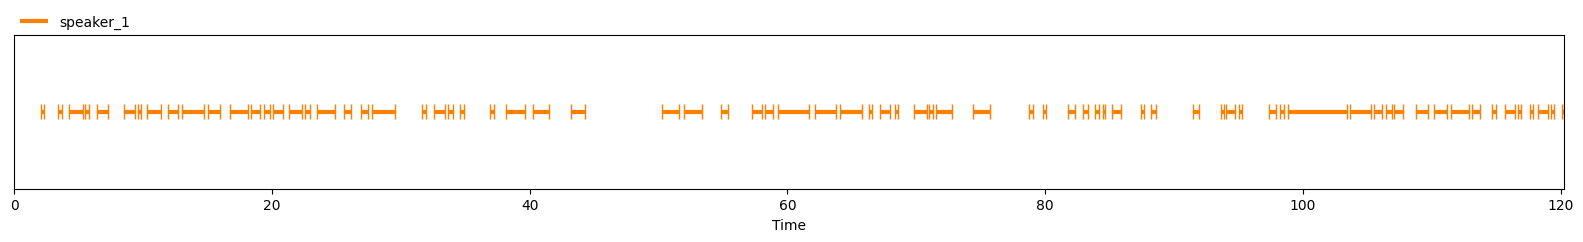

In [5]:
print("Clustering Diarizer Result (RTTM format)")
pred_labels_neural = rttm_to_labels('/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/pred_rttms/e5129809-3652-49b7-8b0f-5cce27255073.rttm')
hypothesis_neural = labels_to_pyannote_object(pred_labels_neural)
hypothesis_neural

In [53]:
# print("Ground-truth Speaker Labels")
# reference

### Neural Diarizer: Multiscale Diarization Decoder with Oracle VAD

The checkpoints (`.ckpt`) or NeMo files (`.nemo`) for **neural diarizers** contain all the necessary neural models for speaker diarization. For example, an MSDD model checkpoint or a NeMo file has pre-trained [TitaNet](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/titanet_large) and MSDD model itself. 

In this tutorial, we use [diar_msdd_telephonic](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/diar_msdd_telephonic) which is optimized for telephic speech. Since we share the same YAML file for all kinds of speaker diarization inference, all we need to do is add model path on top of the config setting for clustering diarizer.

`sigmoid_threshold` is a threshold for making the final binary decision on overlapping speaker label. The lower the value is, the more generous on the speech overlap detection. `sigmoid_threshold` value affects false alarm and miss errors. Default value is `0.7` for telephonic model and if `sigmoid_threshold=1.0`, no overlap speech is detected.

In [54]:
config.diarizer.msdd_model.model_path = 'diar_msdd_telephonic' # Telephonic speaker diarization model 
config.diarizer.msdd_model.parameters.sigmoid_threshold = [0.7, 1.0] # Evaluate with T=0.7 and T=1.0

In [55]:
from nemo.collections.asr.models.msdd_models import NeuralDiarizer
oracle_vad_msdd_model = NeuralDiarizer(cfg=config)

[NeMo I 2023-05-14 15:21:55 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2023-05-14 15:21:55 cloud:58] Found existing object /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2023-05-14 15:21:55 cloud:64] Re-using file from: /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2023-05-14 15:21:55 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-05-14 15:21:56 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2023-05-14 15:21:56 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2023-05-14 15:21:57 modelPT:174] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2023-05-14 15:21:57 features:287] PADDING: 16
[NeMo I 2023-05-14 15:21:57 features:287] PADDING: 16
[NeMo I 2023-05-14 15:21:58 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2023-05-14 15:21:58 features:287] PADDING: 16
[NeMo I 2023-05-14 15:21:59 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2023-05-14 15:21:59 cloud:58] Found existing object /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2023-05-14 15:21:59 cloud:64] Re-using file from: /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2023-05-14 15:21:59 common:913] Instantiating model from pre-trained checkpoi

[NeMo W 2023-05-14 15:21:59 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2023-05-14 15:21:59 features:287] PADDING: 16
[NeMo I 2023-05-14 15:21:59 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.


Unlike clustering diarizer, neural diarizer evaluates diarization results in three different settings by default:

* `collar=0.25`, `ignore_overlap=True`: This is the default setting for evaluating clustering diarizer.
* `collar=0.25`, `ignore_overlap=False`: Still 0.25 s around boundaries are not evaluated but overlaps are evaluated.
* `collar=0.0`, `ignore_overlap=False`: No collar at all and evaluate overlaps. 

Let's run the MSDD model with the prepared configurations.

In [56]:
oracle_vad_msdd_model.diarize()

[NeMo I 2023-05-14 15:22:03 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2023-05-14 15:22:03 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false
    }


[NeMo W 2023-05-14 15:22:03 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2023-05-14 15:22:03 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2023-05-14 15:22:03 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

[NeMo I 2023-05-14 15:22:03 vad_utils:101] The prepared manifest file exists. Overwriting!
[NeMo I 2023-05-14 15:22:03 classification_models:267] Perform streaming frame-level VAD
[NeMo I 2023-05-14 15:22:03 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-14 15:22:03 collections:301] Dataset loaded with 3 items, total duration of  0.03 hours.
[NeMo I 2023-05-14 15:22:03 collections:303] # 3 files loaded accounting to # 1 labels



vad: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

[NeMo I 2023-05-14 15:22:04 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2023-05-14 15:22:06 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

[NeMo I 2023-05-14 15:22:06 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2023-05-14 15:22:06 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-14 15:22:06 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-14 15:22:06 collections:301] Dataset loaded with 118 items, total duration of  0.05 hours.
[NeMo I 2023-05-14 15:22:06 collections:303] # 118 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 2/2 [00:05<00:00,  2.80s/it]

[NeMo I 2023-05-14 15:22:11 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/embeddings
[NeMo I 2023-05-14 15:22:11 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/subsegments_scale1.json


[NeMo I 2023-05-14 15:22:11 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-14 15:22:11 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-14 15:22:11 collections:301] Dataset loaded with 143 items, total duration of  0.05 hours.
[NeMo I 2023-05-14 15:22:11 collections:303] # 143 files loaded accounting to # 1 labels


[2/5] extract embeddings: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


[NeMo I 2023-05-14 15:22:17 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/embeddings
[NeMo I 2023-05-14 15:22:17 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/subsegments_scale2.json
[NeMo I 2023-05-14 15:22:17 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-14 15:22:17 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-14 15:22:17 collections:301] Dataset loaded with 181 items, total duration of  0.05 hours.
[NeMo I 2023-05-14 15:22:17 collections:303] # 181 files loaded accounting to # 1 labels


[3/5] extract embeddings: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

[NeMo I 2023-05-14 15:22:22 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/embeddings
[NeMo I 2023-05-14 15:22:22 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/subsegments_scale3.json
[NeMo I 2023-05-14 15:22:22 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-14 15:22:22 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-14 15:22:22 collections:301] Dataset loaded with 246 items, total duration of  0.05 hours.
[NeMo I 2023-05-14 15:22:22 collections:303] # 246 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]

[NeMo I 2023-05-14 15:22:27 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/embeddings
[NeMo I 2023-05-14 15:22:27 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/subsegments_scale4.json
[NeMo I 2023-05-14 15:22:27 clustering_diarizer:343] Extracting embeddings for Diarization


[NeMo I 2023-05-14 15:22:27 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-14 15:22:27 collections:301] Dataset loaded with 864 items, total duration of  0.12 hours.
[NeMo I 2023-05-14 15:22:27 collections:303] # 864 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 14/14 [00:13<00:00,  1.02it/s]


[NeMo I 2023-05-14 15:22:41 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/embeddings


[NeMo W 2023-05-14 15:22:41 speaker_utils:464] cuda=False, using CPU for eigen decomposition. This might slow down the clustering process.
clustering: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]

[NeMo I 2023-05-14 15:22:43 clustering_diarizer:464] Outputs are saved in /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad directory



[NeMo W 2023-05-14 15:22:43 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2023-05-14 15:22:43 msdd_models:960] Loading embedding pickle file of scale:0 at /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2023-05-14 15:22:43 msdd_models:960] Loading embedding pickle file of scale:1 at /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2023-05-14 15:22:43 msdd_models:960] Loading embedding pickle file of scale:2 at /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2023-05-14 15:22:43 msdd_models:960] Loading embedding pickle file of scale:3 at /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2023-05-14 15:22:43 msdd_models:960] Loading embedding pickle file of scale:4 at /home/auishik/nvidia_nemo/NeMo/tutorials/speake

100%|██████████| 1/1 [00:00<00:00, 13.13it/s]

[NeMo I 2023-05-14 15:22:44 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2023-05-14 15:22:44 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2023-05-14 15:22:44 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2023-05-14 15:22:44 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2023-05-14 15:22:44 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2023-05-14 15:22:44 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2023-05-14 15:22:44 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2023-05-14 15:22:44 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2023-05-14 15:22:44 msdd_models:1431]   
    
[NeMo I 2023-05-14 15:22:44 msdd_models:1403]      [Threshold: 1.0000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2023-05-14 15:22:44 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2023-05-14 15:22:44 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2023-05-14 15:22:44 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2023-05-14 15:22:44 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2023-05-14 15:22:44 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2023-05-14 15:22:44 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2023-05-14 15:22:44 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2023-05-14 15:22:44 msdd_models:1431]   
    


[[None, None, None], [None, None, None]]

The output of the neural diarizer is saved in `outputs/pred_ovl_rttms`.

In [57]:
# !cat /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/pred_rttms/three_speaker.rttm

SPEAKER three_speaker 1   0.140   1.790 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER three_speaker 1   2.700   0.270 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER three_speaker 1   3.260   0.270 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER three_speaker 1   5.740   0.270 <NA> <NA> speaker_1 <NA> <NA>
SPEAKER three_speaker 1   8.860   0.270 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER three_speaker 1   12.220   0.190 <NA> <NA> speaker_1 <NA> <NA>
SPEAKER three_speaker 1   19.100   0.270 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER three_speaker 1   31.900   1.630 <NA> <NA> speaker_1 <NA> <NA>
SPEAKER three_speaker 1   33.740   5.070 <NA> <NA> speaker_1 <NA> <NA>
SPEAKER three_speaker 1   39.420   2.590 <NA> <NA> speaker_1 <NA> <NA>
SPEAKER three_speaker 1   42.300   1.310 <NA> <NA> speaker_1 <NA> <NA>
SPEAKER three_speaker 1   44.700   1.790 <NA> <NA> speaker_1 <NA> <NA>
SPEAKER three_speaker 1   46.700   3.550 <NA> <NA> speaker_1 <NA> <NA>
SPEAKER three_speaker 1   50.700   4.910 <NA> <NA> speaker_1 <NA> <NA>
SPEAKER thr

### Visually Check Diarization Results with Oracle VAD

Visualize the diarization output of clustering diarizer and neural diarizer.

Clustering Diarizer Result


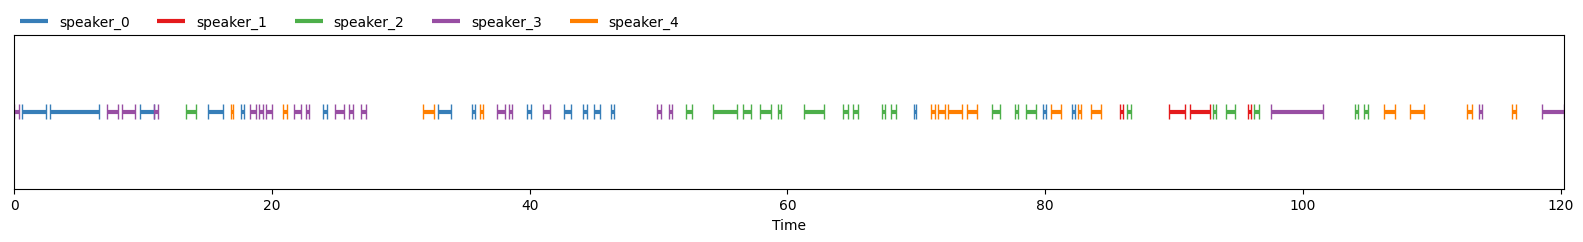

In [6]:
print("Clustering Diarizer Result")
pred_labels_clus = rttm_to_labels('/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/pred_rttms/multi.rttm')
hypothesis_clus = labels_to_pyannote_object(pred_labels_clus)
hypothesis_clus

[NeMo W 2023-07-16 15:55:53 nemo_logging:349] /tmp/ipykernel_12097/2095591861.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
      colors = plt.cm.get_cmap('tab10', len(unique_labels))
    


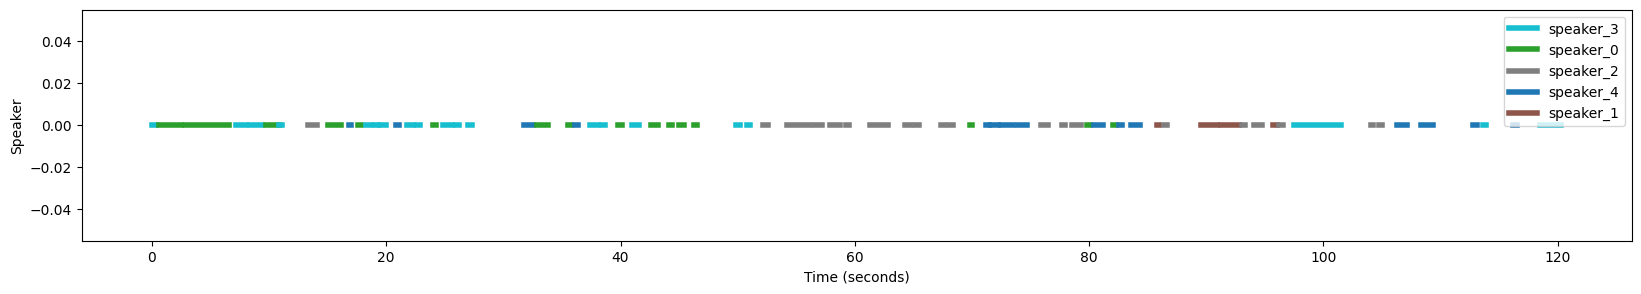

In [7]:
import matplotlib.pyplot as plt

# Read the RTTM file
segments = []
labels = []
with open('/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/pred_rttms/multi.rttm', 'r') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) >= 9 and parts[0] == 'SPEAKER':
            start_time = float(parts[3])
            duration = float(parts[4])
            speaker_id = parts[7]
            segments.append((start_time, start_time + duration))
            labels.append(speaker_id)

# Get unique speaker labels
unique_labels = list(set(labels))

# Assign colors to each unique speaker label
colors = plt.cm.get_cmap('tab10', len(unique_labels))

# Plot the RTTM
plt.figure(figsize=(20, 3))
legend_labels = set()  # Keep track of plotted labels
for segment, label in zip(segments, labels):
    speaker_index = unique_labels.index(label)
    color = colors(speaker_index)
    
    if label not in legend_labels:
        plt.plot(segment, [0, 0], color=color, linewidth=4, linestyle='solid', alpha=1, label=label)
        legend_labels.add(label)
    else:
        plt.plot(segment, [0, 0], color=color, linewidth=4, linestyle='solid', alpha=1)
        
plt.xlabel('Time (seconds)')
plt.ylabel('Speaker')
plt.legend()
plt.show()


In [60]:
print("Neural Diarizer Result")
pred_labels_neural = rttm_to_labels(f'{output_dir}/pred_ovl_rttms/an4_diarize_test.rttm')
hypothesis_neural = labels_to_pyannote_object(pred_labels_neural)
hypothesis_neural

Neural Diarizer Result


FileNotFoundError: [Errno 2] No such file or directory: '/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad/pred_ovl_rttms/an4_diarize_test.rttm'

: 

Ground-truth Speaker Label


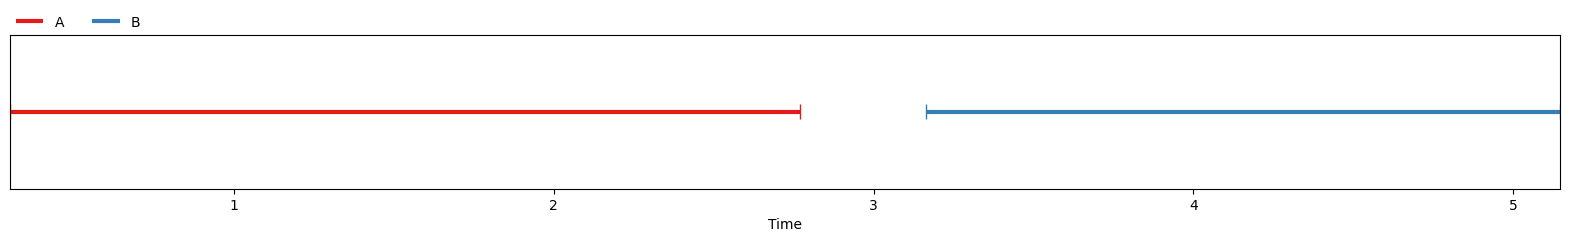

In [ ]:
print("Ground-truth Speaker Label")
reference

# Speaker Diarization with System VAD (NeMo VAD models)

In this section, we actually compute VAD timestamps using a NeMo VAD model on the input manifest file. Next, we use these timestamps for speech/non-speech labels to extract speaker embedding vectors followed by clustering them into num of speakers. As opposed to oracle VAD, the result from an actual VAD model is referred to as __system VAD__.

Before we proceed let's look at the speaker diarization config, which we would be depending up on for vad computation
and speaker embedding extraction.

In [ ]:
print(OmegaConf.to_yaml(config))

name: ClusterDiarizer
num_workers: 1
sample_rate: 16000
batch_size: 64
device: null
verbose: true
diarizer:
  manifest_filepath: data/input_manifest.json
  out_dir: /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/oracle_vad
  oracle_vad: false
  collar: 0.25
  ignore_overlap: true
  vad:
    model_path: vad_multilingual_marblenet
    external_vad_manifest: null
    parameters:
      window_length_in_sec: 0.15
      shift_length_in_sec: 0.01
      smoothing: median
      overlap: 0.5
      onset: 0.1
      offset: 0.1
      pad_onset: 0.1
      pad_offset: 0
      min_duration_on: 0
      min_duration_off: 0.2
      filter_speech_first: true
  speaker_embeddings:
    model_path: titanet_large
    parameters:
      window_length_in_sec:
      - 1.5
      - 1.25
      - 1.0
      - 0.75
      - 0.5
      shift_length_in_sec:
      - 0.75
      - 0.625
      - 0.5
      - 0.375
      - 0.1
      multiscale_weights:
      - 1
      - 1
      - 1
      - 1
      - 1
      save_embeddi

As can be seen most of the variables in config are self explanatory 
with VAD variables under vad section and speaker related variables under speaker embeddings section. 

To perform VAD based diarization we can ignore `oracle_vad_manifest` in `speaker_embeddings` key for now and need to fill up the rest. We also needs to provide pretrained `model_path` of vad and speaker embeddings .nemo models.

In [ ]:
pretrained_vad = 'vad_multilingual_marblenet'
pretrained_speaker_model = 'titanet_large'

Note in this tutorial, we use the VAD model *vad_multilingual_marblenet* which is an improved model based on MarbleNet-3x2 that has been introduced and published in [ICASSP MarbleNet](https://arxiv.org/pdf/2010.13886.pdf). You might need to tune on dev set similar to your dataset if you would like to improve the performance.

And the speakerNet-M-Diarization model achieves 7.3% confusion error rate on CH109 set with oracle vad. This model is trained on voxceleb1, voxceleb2, Fisher, SwitchBoard datasets. So for more improved performance specific to your dataset, finetune speaker verification model with a devset similar to your test set.

It is recommended to set `num_workers=1` since using the multiprocessing package in Jupyter Notebook environment might cause freezing issues. For sizable data, run speaker diarization using the scripts in `NeMo/examples/speaker_tasks/` setting `num_workers` larger than 1 in the configurations.

You can play with parameters in configurations as below.

In [ ]:
config.num_workers = 1 # Workaround for multiprocessing hanging with ipython issue 

output_dir = os.path.join(ROOT, 'outputs')
config.diarizer.manifest_filepath = 'data/input_manifest.json'
config.diarizer.out_dir = output_dir #Directory to store intermediate files and prediction outputs

config.diarizer.speaker_embeddings.model_path = pretrained_speaker_model
config.diarizer.oracle_vad = False # compute VAD provided with model_path to vad config
config.diarizer.clustering.parameters.oracle_num_speakers=False

# Here, we use our in-house pretrained NeMo VAD model
config.diarizer.vad.model_path = pretrained_vad
config.diarizer.vad.parameters.onset = 0.8
config.diarizer.vad.parameters.offset = 0.6
config.diarizer.vad.parameters.pad_offset = -0.05

### Clustering Diarizer: with System VAD

Now that we passed all the variables we need, let's initialize the clustering diarizer model with the configurations we set. 

In [ ]:
from nemo.collections.asr.models import ClusteringDiarizer
sd_model = ClusteringDiarizer(cfg=config)

[NeMo I 2023-05-13 14:36:06 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2023-05-13 14:36:06 cloud:58] Found existing object /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2023-05-13 14:36:06 cloud:64] Re-using file from: /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2023-05-13 14:36:06 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-05-13 14:36:06 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2023-05-13 14:36:06 features:287] PADDING: 16
[NeMo I 2023-05-13 14:36:06 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2023-05-13 14:36:06 clustering_diarizer:157] Loading pretrained titanet_large model from NGC
[NeMo I 2023-05-13 14:36:06 cloud:58] Found existing object /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/titanet-l/11ba0924fdf87c049e339adbf6899d48/titanet-l.nemo.
[NeMo I 2023-05-13 14:36:06 cloud:64] Re-using file from: /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/titanet-l/11ba0924fdf87c049e339adbf6899d48/titanet-l.nemo
[NeMo I 2023-05-13 14:36:06 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-05-13 14:36:06 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2023-05-13 14:36:06 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method 

[NeMo I 2023-05-13 14:36:06 features:287] PADDING: 16
[NeMo I 2023-05-13 14:36:07 save_restore_connector:249] Model EncDecSpeakerLabelModel was successfully restored from /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/titanet-l/11ba0924fdf87c049e339adbf6899d48/titanet-l.nemo.


And launch diarization with a single line of code.

In [ ]:
sd_model.diarize()

[NeMo W 2023-05-13 13:36:16 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2023-05-13 13:36:16 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2023-05-13 13:36:16 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]

[NeMo I 2023-05-13 13:36:17 vad_utils:101] The prepared manifest file exists. Overwriting!
[NeMo I 2023-05-13 13:36:17 classification_models:267] Perform streaming frame-level VAD
[NeMo I 2023-05-13 13:36:17 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-13 13:36:17 collections:301] Dataset loaded with 6 items, total duration of  0.08 hours.
[NeMo I 2023-05-13 13:36:17 collections:303] # 6 files loaded accounting to # 1 labels



vad: 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

[NeMo I 2023-05-13 13:36:18 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2023-05-13 13:36:22 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

[NeMo I 2023-05-13 13:36:22 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2023-05-13 13:36:22 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-13 13:36:22 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-13 13:36:22 collections:301] Dataset loaded with 208 items, total duration of  0.06 hours.
[NeMo I 2023-05-13 13:36:22 collections:303] # 208 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  6.50it/s]

[NeMo I 2023-05-13 13:36:23 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/embeddings
[NeMo I 2023-05-13 13:36:23 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2023-05-13 13:36:23 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-13 13:36:23 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-13 13:36:23 collections:301] Dataset loaded with 255 items, total duration of  0.07 hours.
[NeMo I 2023-05-13 13:36:23 collections:303] # 255 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  6.58it/s]

[NeMo I 2023-05-13 13:36:23 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/embeddings
[NeMo I 2023-05-13 13:36:23 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/subsegments_scale2.json


[NeMo I 2023-05-13 13:36:23 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-13 13:36:23 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-13 13:36:23 collections:301] Dataset loaded with 302 items, total duration of  0.07 hours.
[NeMo I 2023-05-13 13:36:23 collections:303] # 302 files loaded accounting to # 1 labels


[3/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  7.63it/s]

[NeMo I 2023-05-13 13:36:24 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/embeddings
[NeMo I 2023-05-13 13:36:24 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/subsegments_scale3.json


[NeMo I 2023-05-13 13:36:24 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-13 13:36:24 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-13 13:36:24 collections:301] Dataset loaded with 404 items, total duration of  0.08 hours.
[NeMo I 2023-05-13 13:36:24 collections:303] # 404 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 7/7 [00:00<00:00,  9.72it/s]


[NeMo I 2023-05-13 13:36:25 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/embeddings
[NeMo I 2023-05-13 13:36:25 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2023-05-13 13:36:25 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-13 13:36:25 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-13 13:36:25 collections:301] Dataset loaded with 1265 items, total duration of  0.17 hours.
[NeMo I 2023-05-13 13:36:25 collections:303] # 1265 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 20/20 [00:01<00:00, 15.85it/s]

[NeMo I 2023-05-13 13:36:26 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

[NeMo I 2023-05-13 13:36:27 clustering_diarizer:464] Outputs are saved in /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs directory



[NeMo W 2023-05-13 13:36:27 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


As can be seen, we first performed VAD, then with the timestamps created in `{output_dir}/vad_outputs` by VAD we calculated speaker embeddings (`{output_dir}/speaker_outputs/embeddings/`) which are then clustered using spectral clustering. 

Generating predicted  VAD timesteps: We perform VAD inference to have frame level prediction &#8594; (optional: use decision smoothing) &#8594; given `threshold`,  write speech segments to a RTTM-like timestamp manifest file.

We use VAD decision smoothing (50% overlap median) as described in [vad_utils.py](https://github.com/NVIDIA/NeMo/blob/stable/nemo/collections/asr/parts/utils/vad_utils.py).

You can also tune the threshold on your dev set. Use this provided in [vad_tune_threshold.py](https://github.com/NVIDIA/NeMo/blob/stable/scripts/voice_activity_detection/vad_tune_threshold.py).

In [ ]:
# VAD predicted time stamps
# you can also use single threshold(=onset=offset) for binarization and plot here
from nemo.collections.asr.parts.utils.vad_utils import plot

if config.diarizer.vad.parameters.smoothing:
    vad_output_filepath = f'{output_dir}/vad_outputs/overlap_smoothing_output_median_{config.diarizer.vad.parameters.overlap}/an4_diarize_test.{config.diarizer.vad.parameters.smoothing}'
else:
    vad_output_filepath = f'{output_dir}/vad_outputs/an4_diarize_test.frame'

plot(
    an4_audio,
    vad_output_filepath, 
    an4_rttm,
    per_args = config.diarizer.vad.parameters, #threshold
    ) 

print(f"VAD params:{OmegaConf.to_yaml(config.diarizer.vad.parameters)}")

FileNotFoundError: [Errno 2] No such file or directory: '/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/vad_outputs/overlap_smoothing_output_median_0.5/an4_diarize_test.median'

<Figure size 2000x200 with 0 Axes>

: 

Predicted outputs are written to `{output_dir}/pred_rttms` and see how we predicted along with VAD prediction

In [ ]:
!cat {output_dir}/pred_rttms/an4_diarize_test.rttm

SPEAKER an4_diarize_test 1   0.300   2.540 <NA> <NA> speaker_1 <NA> <NA>
SPEAKER an4_diarize_test 1   3.180   1.970 <NA> <NA> speaker_0 <NA> <NA>


### Neural Diarizer: Multiscale Diarization Decoder with System VAD

We can run a neural diarizer model without changing many parameters since neural diarizer also performs VAD and clustering diarizer. All we need to do is run the MSDD model with the new config file.

In [ ]:
config.diarizer.msdd_model.model_path = 'diar_msdd_telephonic' # Telephonic speaker diarization model 
config.diarizer.msdd_model.parameters.sigmoid_threshold = [0.7, 1.0] # Evaluate with T=0.7 and T=1.0
system_vad_msdd_model = NeuralDiarizer(cfg=config)

[NeMo I 2023-05-10 15:18:40 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2023-05-10 15:18:40 cloud:58] Found existing object /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2023-05-10 15:18:40 cloud:64] Re-using file from: /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2023-05-10 15:18:40 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-05-10 15:18:41 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2023-05-10 15:18:41 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2023-05-10 15:18:41 modelPT:174] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2023-05-10 15:18:41 features:287] PADDING: 16
[NeMo I 2023-05-10 15:18:41 features:287] PADDING: 16
[NeMo I 2023-05-10 15:18:42 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2023-05-10 15:18:42 features:287] PADDING: 16
[NeMo I 2023-05-10 15:18:43 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2023-05-10 15:18:43 cloud:58] Found existing object /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2023-05-10 15:18:43 cloud:64] Re-using file from: /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2023-05-10 15:18:43 common:913] Instantiating model from pre-trained checkpoi

[NeMo W 2023-05-10 15:18:43 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2023-05-10 15:18:43 features:287] PADDING: 16
[NeMo I 2023-05-10 15:18:44 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.


In [ ]:
system_vad_msdd_model.diarize()

[NeMo I 2023-05-10 15:18:52 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2023-05-10 15:18:52 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false
    }


[NeMo W 2023-05-10 15:18:52 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2023-05-10 15:18:52 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2023-05-10 15:18:52 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 349.82it/s]

[NeMo I 2023-05-10 15:18:52 vad_utils:101] The prepared manifest file exists. Overwriting!
[NeMo I 2023-05-10 15:18:52 classification_models:267] Perform streaming frame-level VAD
[NeMo I 2023-05-10 15:18:52 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-10 15:18:52 collections:301] Dataset loaded with 1 items, total duration of  0.00 hours.
[NeMo I 2023-05-10 15:18:52 collections:303] # 1 files loaded accounting to # 1 labels



vad: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

[NeMo I 2023-05-10 15:18:53 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2023-05-10 15:18:53 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00, 165.34it/s]

[NeMo I 2023-05-10 15:18:53 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2023-05-10 15:18:53 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-10 15:18:53 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-10 15:18:53 collections:301] Dataset loaded with 5 items, total duration of  0.00 hours.
[NeMo I 2023-05-10 15:18:53 collections:303] # 5 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

[NeMo I 2023-05-10 15:18:53 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/embeddings
[NeMo I 2023-05-10 15:18:53 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2023-05-10 15:18:53 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-10 15:18:53 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-10 15:18:53 collections:301] Dataset loaded with 7 items, total duration of  0.00 hours.
[NeMo I 2023-05-10 15:18:53 collections:303] # 7 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

[NeMo I 2023-05-10 15:18:54 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/embeddings
[NeMo I 2023-05-10 15:18:54 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2023-05-10 15:18:54 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-10 15:18:54 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-10 15:18:54 collections:301] Dataset loaded with 8 items, total duration of  0.00 hours.
[NeMo I 2023-05-10 15:18:54 collections:303] # 8 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

[NeMo I 2023-05-10 15:18:54 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/embeddings
[NeMo I 2023-05-10 15:18:54 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2023-05-10 15:18:54 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-10 15:18:54 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-10 15:18:54 collections:301] Dataset loaded with 11 items, total duration of  0.00 hours.
[NeMo I 2023-05-10 15:18:54 collections:303] # 11 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

[NeMo I 2023-05-10 15:18:55 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/embeddings
[NeMo I 2023-05-10 15:18:55 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2023-05-10 15:18:55 clustering_diarizer:343] Extracting embeddings for Diarization


[NeMo I 2023-05-10 15:18:55 collections:298] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-10 15:18:55 collections:301] Dataset loaded with 38 items, total duration of  0.01 hours.
[NeMo I 2023-05-10 15:18:55 collections:303] # 38 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

[NeMo I 2023-05-10 15:18:56 clustering_diarizer:389] Saved embedding files to /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/embeddings



[NeMo W 2023-05-10 15:18:56 speaker_utils:464] cuda=False, using CPU for eigen decomposition. This might slow down the clustering process.
clustering: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

[NeMo I 2023-05-10 15:18:57 clustering_diarizer:464] Outputs are saved in /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs directory



[NeMo W 2023-05-10 15:18:57 nemo_logging:349] /home/auishik/miniconda3/envs/nemo/lib/python3.8/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
      warnings.warn(
    


[NeMo I 2023-05-10 15:18:57 der:176] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2023-05-10 15:18:57 msdd_models:960] Loading embedding pickle file of scale:0 at /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2023-05-10 15:18:57 msdd_models:960] Loading embedding pickle file of scale:1 at /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2023-05-10 15:18:57 msdd_models:960] Loading embedding pickle file of scale:2 at /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2023-05-10 15:18:57 msdd_models:960] Loading embedding pickle file of scale:3 at /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/speaker_outputs/

100%|██████████| 1/1 [00:00<00:00, 89.35it/s]

[NeMo I 2023-05-10 15:18:57 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2023-05-10 15:18:57 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2023-05-10 15:18:57 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2023-05-10 15:18:57 der:176] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2023-05-10 15:18:57 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2023-05-10 15:18:57 der:176] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2023-05-10 15:18:57 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2023-05-10 15:18:57 der:176] Cumulative Results for collar 0.0 sec and ignore_overlap False: 
     FA: 0.0164	 MISS 0.0038	                 Diarization ER: 0.0202	, Confusion ER:0.0000
[Ne

[[(<pyannote.metrics.diarization.DiarizationErrorRate at 0x7f4f80c02040>,
   {'an4_diarize_test': {'speaker_0': 'B', 'speaker_1': 'A'}},
   (0.0, 0.0, 0.0, 0.0)),
  (<pyannote.metrics.diarization.DiarizationErrorRate at 0x7f4fe8aa85e0>,
   {'an4_diarize_test': {'speaker_0': 'B', 'speaker_1': 'A'}},
   (0.0, 0.0, 0.0, 0.0)),
  (<pyannote.metrics.diarization.DiarizationErrorRate at 0x7f4f80bf5430>,
   {'an4_diarize_test': {'speaker_0': 'B', 'speaker_1': 'A'}},
   (0.02020655590480466, 0.0, 0.016389762011674885, 0.003816793893129774))],
 [(<pyannote.metrics.diarization.DiarizationErrorRate at 0x7f4fe8a97550>,
   {'an4_diarize_test': {'speaker_0': 'B', 'speaker_1': 'A'}},
   (0.0, 0.0, 0.0, 0.0)),
  (<pyannote.metrics.diarization.DiarizationErrorRate at 0x7f4fe8a9ed60>,
   {'an4_diarize_test': {'speaker_0': 'B', 'speaker_1': 'A'}},
   (0.0, 0.0, 0.0, 0.0)),
  (<pyannote.metrics.diarization.DiarizationErrorRate at 0x7f4fef495280>,
   {'an4_diarize_test': {'speaker_0': 'B', 'speaker_1': 'A'}

Check whether diarization saved in `outputs/pred_ovl_rttms` is correct.

In [ ]:
!cat {output_dir}/pred_ovl_rttms/an4_diarize_test.rttm

cat: /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/pred_ovl_rttms/an4_diarize_test.rttm: No such file or directory


### Visually Check Diarization Results with System VAD

Visualize the diarization output of clustering diarizer and neural diarizer.

Clustering Diarizer Result (RTTM format)


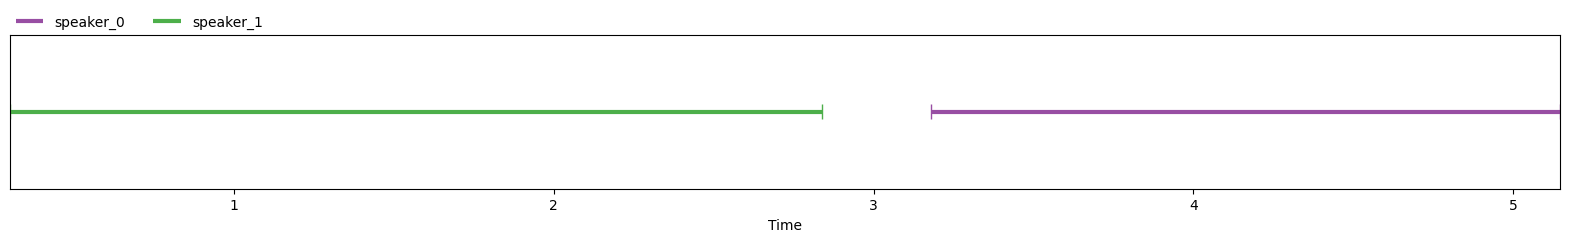

In [ ]:
print("Clustering Diarizer Result (RTTM format)")
pred_labels_clus = rttm_to_labels(f'{output_dir}/pred_rttms/an4_diarize_test.rttm')
hypothesis_clus = labels_to_pyannote_object(pred_labels_clus)
hypothesis_clus

In [ ]:
print("Neural Diarizer Result (RTTM format)")
pred_labels_neural = rttm_to_labels(f'{output_dir}/pred_ovl_rttms/an4_diarize_test.rttm')
hypothesis_neural = labels_to_pyannote_object(pred_labels_neural)
hypothesis_neural

Neural Diarizer Result (RTTM format)


FileNotFoundError: [Errno 2] No such file or directory: '/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/outputs/pred_ovl_rttms/an4_diarize_test.rttm'

Ground-truth Speaker Label (RTTM format)


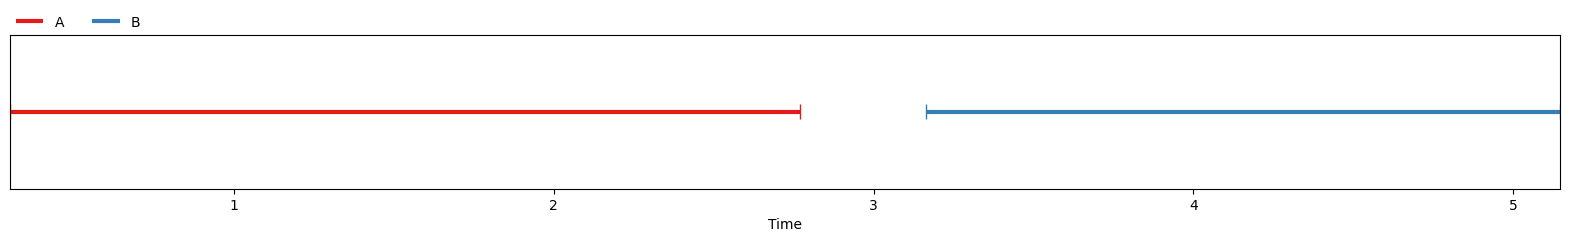

In [ ]:
print("Ground-truth Speaker Label (RTTM format)")
reference

# Storing and Restoring models

For clustering diarizer, we can save the whole config and model parameters in a single .nemo and restore from it anytime. Neural diarizer will support this feature soon.

In [ ]:
oracle_vad_clusdiar_model.save_to(os.path.join(output_dir,'clustering_diarizer.nemo'))

Restore from saved model

In [ ]:
del oracle_vad_clusdiar_model
import nemo.collections.asr as nemo_asr
restored_model = nemo_asr.models.ClusteringDiarizer.restore_from(os.path.join(output_dir,'clustering_diarizer.nemo'))